In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D,SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from tensorflow.keras.optimizers import Adam,SGD

In [20]:
data_dir = '/home/webwerks/acne_classification/dataset/'
img_height = 300
img_width =300
batch_size = 24
IMG_SIZE = (img_height,img_width)
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 999 files belonging to 3 classes.
Using 800 files for training.
Found 999 files belonging to 3 classes.
Using 199 files for validation.


In [4]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

random_invert = random_invert()
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
#     RandomInvert()
])

In [5]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [6]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [7]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [8]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2022-06-09 16:40:13.051832: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-06-09 16:40:13.922982: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-06-09 16:40:13.925220: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 7.5
2022-06-09 16:40:13.925244: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-06-09 16:40:13.925335: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be o

(24, 9, 9, 512)


In [9]:
base_model.trainable = False

In [10]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(24, 512)


In [12]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(24, 3)


In [13]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
# from tensorflow.keras import layers, models

# flatten_layer = layers.Flatten()
# dense_layer_1 = layers.Dense(50, activation='relu')
# dense_layer_2 = layers.Dense(20, activation='relu')
# prediction_layer = layers.Dense(3, activation='softmax')


# model = models.Sequential([
#     base_model,
#     flatten_layer,
#     dense_layer_1,
#     dense_layer_2,
#     prediction_layer
# ])


In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
initial_epochs = 30

loss0, accuracy0 = model.evaluate(val_ds)

9/9 [==============================] - 3s 243ms/step - loss: 1.4189 - accuracy: 0.3819


In [16]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/30
34/34 [==============================] - 10s 240ms/step - loss: 2.2499 - accuracy: 0.2587 - val_loss: 1.1469 - val_accuracy: 0.1407
Epoch 2/30
34/34 [==============================] - 8s 220ms/step - loss: 1.9016 - accuracy: 0.2625 - val_loss: 1.0687 - val_accuracy: 0.1206
Epoch 3/30
34/34 [==============================] - 8s 220ms/step - loss: 1.6550 - accuracy: 0.2313 - val_loss: 1.0520 - val_accuracy: 0.1206
Epoch 4/30
34/34 [==============================] - 8s 220ms/step - loss: 1.4876 - accuracy: 0.2325 - val_loss: 1.0398 - val_accuracy: 0.1206
Epoch 5/30
34/34 [==============================] - 8s 222ms/step - loss: 1.6409 - accuracy: 0.2425 - val_loss: 1.0268 - val_accuracy: 0.1256
Epoch 6/30
34/34 [==============================] - 8s 222ms/step - loss: 1.5966 - accuracy: 0.2325 - val_loss: 1.0166 - val_accuracy: 0.1256
Epoch 7/30
34/34 [==============================] - 8s 226ms/step - loss: 1.5196 - accuracy: 0.2250 - val_loss: 1.0169 - val_accuracy: 0.1256
Epoch

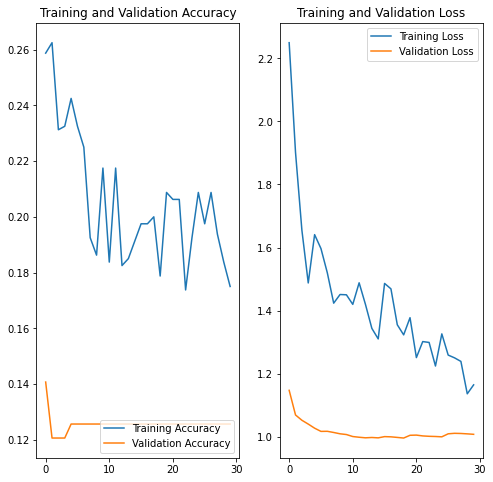

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
model.save("acne_classification_vgg19_v2.h5")